In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv('AmesHousing.tsv',sep='\t')

In [3]:
df.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [4]:
def seasons(value):
    '''
    Categorizes each month into seasons
    '''
    seasons_cat = {
        'winter':[12,1,2],
        'spring':[3,4,5],
        'summer':[6,7,8],
        'fall':[9,10,11]
    }
    
    for season in seasons_cat.keys():
        if value in seasons_cat[season]:
            return season

In [5]:
def find_noms(dataframe):
    '''
    "Good" nominal variables are those with 5 or less categories and 
    that have no categories with more than 95% of values in it
    '''
    good_nom = [] # to store nominal 
    # Drop variables with lots of nans
    nominal = dataframe.select_dtypes(object)
    nans = nominal.isna().sum()
    nans_5 = nans[nans < len(nominal) * 0.05]
    nominal = nominal[nans_5.index]

    for col in nominal.columns:
        nom_series = nominal[col].value_counts()
        perc = nom_series.apply(lambda x: x/nom_series.sum()*100)
        if (len(perc)<= 5) & ((perc > 95).sum() == 0):
            good_nom.append(col)
            
    return good_nom

In [6]:
def transform_features(dataframe):
    '''
    Returns dataframe with only columns that 
    have < 5% missing features, and transforms cols to
    categorical as needed.
    '''
    na_count = df.isna().sum()
    
    # Filter to columns that contain < 5% nans
    cols_25 = na_count[na_count < len(dataframe)*0.05].index
    
    # New columns
    new_df = dataframe.copy()[cols_25]
    new_df['years_until_remod'] = new_df['Year Remod/Add'] - new_df['Year Built']
    new_df['age_when_sold'] = new_df['Yr Sold'] - new_df['Year Built']
    new_df['condition_when_sold'] = new_df['Yr Sold'] - new_df['Year Remod/Add']
    new_df['season_sold'] = new_df['Mo Sold'].apply(seasons)
    
    # Grab nominal columns
    nom_cols = find_noms(new_df)
    print("The following nominal fratures are worth investigating:")
    print(nom_cols)
    
    # Select numerical columns
    nums = new_df.select_dtypes([int, float])
    
    # Drop columns that aren't useful or ML
    nums = nums.drop(['Order','PID','Year Built',
                      'Year Remod/Add','Total Bsmt SF',
                      'TotRms AbvGrd','Garage Cars',
                      'Mo Sold','Yr Sold'
                     ],axis=1)
    new_cols = list(nums.columns) + nom_cols
    
    # Select appropriate columns
    good_df = new_df[new_cols]
    
    for col in good_df.columns:
        # fill nan values with the mean if the column is numerical
        if (good_df[col].dtype == int) | (good_df[col].dtype == float):
            good_df[col] = good_df[col].fillna(good_df[col].mean())
    return good_df

In [22]:
new_df = transform_features(df)

The following nominal fratures are worth investigating:
['Lot Shape', 'Land Contour', 'Lot Config', 'Bldg Type', 'Mas Vnr Type', 'Exter Qual', 'Exter Cond', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'Heating QC', 'Central Air', 'Electrical', 'Kitchen Qual', 'Paved Drive', 'season_sold']


<ipython-input-6-28548cb943ba>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  good_df[col] = good_df[col].fillna(good_df[col].mean())


Good candidates for linear regression are variables that highly correlate with `SalePrice`, and have high variance

<AxesSubplot:>

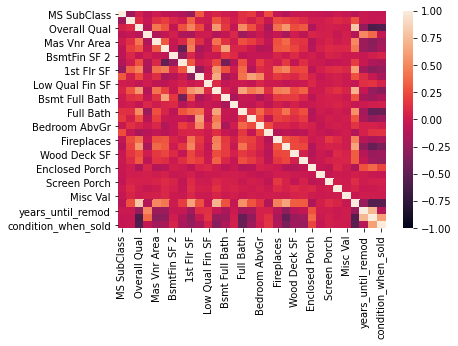

In [23]:
sns.heatmap(new_df.corr(), vmin=-1,vmax=1)

In [10]:
corr = abs(new_df.corr()['SalePrice']).sort_values(ascending=False).reset_index()
var = new_df.var().sort_values(ascending=False).reset_index()

corr_var = pd.merge(corr,var)
corr_var.columns = ['variable','correlation','variance']
corr_var.sort_values('correlation',ascending=False)

,variable,correlation,variance
0,SalePrice,1.000000,6.381884e+09
1,Overall Qual,0.799262,1.990995e+00
2,Gr Liv Area,0.706780,2.555392e+05
3,Garage Area,0.640385,4.622923e+04
4,1st Flr SF,0.621676,1.535785e+05
5,age_when_sold,0.558907,9.175663e+02
6,Full Bath,0.545604,3.057433e-01
7,condition_when_sold,0.534940,4.350914e+02
8,Mas Vnr Area,0.505784,3.182941e+04
9,Fireplaces,0.474558,4.198015e-01


In [11]:
def select_features(dataframe):
    '''
    Returns features
    '''
    new_df = dataframe.copy()[['SalePrice','Gr Liv Area','1st Flr SF','Garage Area',
                      'age_when_sold','condition_when_sold','Mas Vnr Area']]
    return new_df

In [12]:
new_df = select_features(new_df)

In [13]:
def train_and_test(dataframe, k=0):
    '''
    Trains, tests, and calculates RMSE for model
    '''
    lr = LinearRegression()
    
    if k == 0:
        train = dataframe.loc[:1459,:]
        test = dataframe.loc[1460:,:]

        X_train = train.drop('SalePrice',axis=1)
        y_train = train['SalePrice']

        X_test = test.drop('SalePrice',axis=1)
        y_test = test['SalePrice']

        lr.fit(X_train, y_train)

        y_predict = lr.predict(X_test)
        mse = mean_squared_error(y_test, y_predict)
        rmse = np.sqrt(mse)

        return rmse
    # k-fold cross validation
    elif k == 1:
        new_df = dataframe.sample(frac=1, random_state=42)
        fold_one = new_df.loc[:1459,:]
        fold_two = new_df.loc[1460:,:]
        
        fold_one_X = fold_one.drop('SalePrice',axis=1)
        fold_one_y = fold_one['SalePrice']
        fold_two_X = fold_two.drop('SalePrice',axis=1)
        fold_two_y = fold_two['SalePrice']
        
        # train on fold_one, test on fold_two
        lr.fit(fold_one_X, fold_one_y)
        fold_two_predict = lr.predict(fold_two_X)
        mse2 = mean_squared_error(fold_two_y, fold_two_predict)
        rmse2 = np.sqrt(mse2)
        
        # train on fold_two, test on fold_one
        lr.fit(fold_two_X, fold_two_y)
        fold_one_predict = lr.predict(fold_one_X)
        mse1 = mean_squared_error(fold_one_y, fold_one_predict)
        rmse1 = np.sqrt(mse1)
        
        # return the average of the two rmse
        return (rmse1+rmse2)/2
    elif k > 1:
        from sklearn.model_selection import KFold
        X = dataframe.drop('SalePrice',axis=1)
        y = dataframe['SalePrice']
        kf = KFold(n_splits = k,shuffle=True ,random_state=42)
        
        rmse_list = []
        
        for train, test in kf.split(X):
            X_train, X_test = X.iloc[train,:], X.iloc[test,:]
            y_train, y_test = y[train], y[test]
        
            lr.fit(X_train, y_train)
            predict = lr.predict(X_test)
            rmse = np.sqrt(mean_squared_error(y_test, predict))
            rmse_list.append(rmse)
        return np.mean(rmse_list)
            
            

In [14]:
x = range(0,35)
y = []

for i in range(0,35):
    rmse = train_and_test(new_df, k=i)
    y.append(rmse)

Text(0, 0.5, 'RMSE')

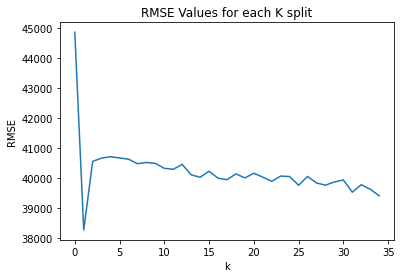

In [18]:
sns.lineplot(x=x,y=y)
plt.title('RMSE Values for each K split')
plt.xlabel('k')
plt.ylabel('RMSE')

In [24]:
pd.DataFrame({'x':x,'y':y}).sort_values('y').head(5)

,x,y
1,1,38260.474068
34,34,39398.096454
31,31,39519.903800
33,33,39620.549537
25,25,39751.605520


The optimum k for k-fold cross validation is 1, resulting in an RMSE of $38,260.47